## GWDALI Example (Estimating BBH parameters with LIGO-H, LIGO-L, Virgo and KAGRA)

### Requirements (Python Packages):
    * 'numpy',
    * 'matplotlib',
    * 'scipy',
    * 'tqdm',
    * 'bilby',
    * 'nestle',
    * 'emcee',
    * 'astropy',
    * 'itertools',
    * 'lal', (Only for waveform generation from LIGO libraries) - Install via anaconda
    * 'lalsimulation', (Only for waveform generation from LIGO libraries) - Install via anaconda
    * 'cartopy', (Only for world-map plot)

### Importing Libraries:

In [1]:
import numpy as np
#-------------------
import GWDALI as gw
#-------------------
from tqdm import trange
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(70,0.3)

### Setting detector sensitivity, position and orientation:

In [2]:
FreeParams = ['DL','iota','psi']

rot_LHO = 180+36
rot_LLO = 270+18
rot_Virgo = 180-19
rot_KAGRA = 90+28.31

det1 = {"name":"aLIGO","lon":-119.4073,"lat":46.4554,"rot":rot_LHO,"shape":90} # Hanford
det2 = {"name":"aLIGO","lon":-90.7740,"lat":30.5629,"rot":rot_LLO,"shape":90} # Livingston
det3 = {"name":"aVirgo","lon":10.5024,"lat":43.6279,"rot":rot_Virgo,"shape":90}
det4 = {"name":"KAGRA","lon":137.1761,"lat":36.2539,"rot":rot_KAGRA,"shape":90}

rad = np.pi/180 ; deg = 1./rad

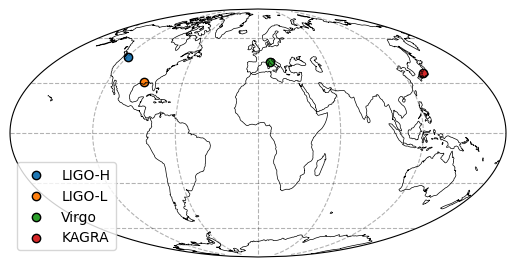

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as cp

ax = plt.subplot(111,projection=cp.Mollweide())
ax.scatter(det1['lon'],det1['lat'],edgecolor='k',transform=cp.PlateCarree(),label='LIGO-H')
ax.scatter(det2['lon'],det2['lat'],edgecolor='k',transform=cp.PlateCarree(),label='LIGO-L')
ax.scatter(det3['lon'],det3['lat'],edgecolor='k',transform=cp.PlateCarree(),label='Virgo')
ax.scatter(det4['lon'],det4['lat'],edgecolor='k',transform=cp.PlateCarree(),label='KAGRA')
plt.legend(loc='lower left')
ax.coastlines(lw=.5)
ax.set_global()
ax.gridlines(ls='--',color='k',alpha=0.3)
plt.show()

### Setting Injections of a Binary of Black Holes (Single detection):

In [4]:
z = 0.3 # Redshift

params = {}
params['m1']  = 25*(1+z) # mass of the first object [solar mass]
params['m2']  = 30*(1+z) # mass of the second object [solar mass]
params['z']   = z
params['RA']       = 0
params['Dec']      = 45
params['DL']       = cosmo.luminosity_distance(z).value/1.e3 # Gpc
params['iota']     = np.pi/6          # Inclination angle (rad)
params['psi']      = np.pi/3 # Polarization angle (rad)
params['t_coal']   = 0  # Coalescence time
params['phi_coal'] = 0  # Coalescence phase
# Spins:
params['sx1'] = 0
params['sy1'] = 0
params['sz1'] = 0
params['sx2'] = 0
params['sy2'] = 0
params['sz2'] = 0

### Changing priors of DL (or for other parameters)

In [5]:
x = np.linspace(0,100,1000)
y = np.exp(-0.5*(x-50)**2/100)
new_priors = {}
new_priors['DL'] = [x,y]

### Running GWDALI with LIGO-H, LIGO-L, Virgo and KAGRA

In [6]:
res = gw.GWDALI( Detection_Dict = params,
                 FreeParams     = FreeParams,
                 detectors      = [det1,det2,det3,det4],
                 approximant    = 'TaylorF2_py',
                 dali_method    = 'Fisher_Sampling',
                 sampler_method = 'nestle', # Same as Bilby sampling method
                 new_priors     = new_priors,
                 fmin           = 1,
                 fmax           = 3000,
                 fsize          = 1000,
                 save_fisher    = False,
                 save_cov       = False,
                 plot_corner    = False,
                 save_samples   = False,
                 hide_info      = True,
                 index          = 1,
                 rcond          = 1.e-4,
                 npoints=300) # points for "nested sampling" or steps/walkers for "MCMC"
print("\n GWDALI Concluded!\n")

it=  6908 logz=-22.60790602794

 GWDALI Concluded!



### Getting the results:

In [7]:
Samples = res['Samples']
Fisher  = res['Fisher']
CovFish = res['CovFisher']
Cov     = res['Covariance']
Rec     = res['Recovery']
Err     = res['Error']
SNR     = res['SNR']

In [8]:
print(SNR) # Source SNR for each detector

[12.534681747121407, 11.966452759875313, 20.33255581206879, 12.914261074538825]


In [9]:
print(Rec) # Recovered Parameters

[1.167819845128105, 0.9996328370774722, 1.0461460681708235]


In [10]:
print(Err) # Uncertainties in each parameter

[0.3620312894229695, 0.44984654981423616, 0.014214215530806595]


In [11]:
print(Fisher) # Fisher Matrix

[[ 3.65214413e+02  2.95265378e+02 -1.70722797e+00]
 [ 2.95265378e+02  2.40001441e+02  9.18278400e+00]
 [-1.70722797e+00  9.18278400e+00  3.49559763e+03]]


In [12]:
print(Cov) # Covariance Matrix (From Samples)

[[ 0.15727763 -0.19138197  0.00050938]
 [-0.19138197  0.23677101 -0.00058504]
 [ 0.00050938 -0.00058504  0.00028162]]


In [13]:
print(CovFish) # Covariance Matrix (From numerical Fisher Matrix inversion)

[[ 5.23186833e-01 -6.43732937e-01  1.94657979e-03]
 [-6.43732937e-01  7.96220814e-01 -2.40603282e-03]
 [ 1.94657979e-03 -2.40603282e-03  2.93345357e-04]]


### Plotting the posteriors ('corner' required):

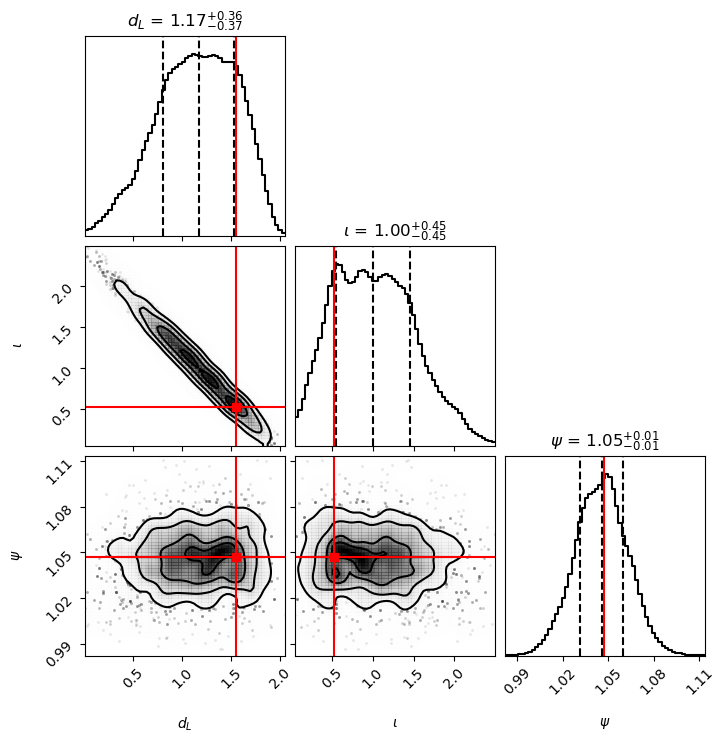

In [14]:
from corner import corner
import matplotlib.pyplot as plt
fig = corner(Samples,smooth=2,smooth1d=2,bins=60,
      truths=[params['DL'],params['iota'],params['psi']],quantiles=[0.2,0.5,0.8],
      labels=['$d_L$','$\iota$','$\psi$'],truth_color='red',show_titles=True )
fig.savefig('corner_gwdali.png')
plt.show()